In [2]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\Delbert\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
year = pd.read_csv("BTC-USD.csv")
year["Date"] = pd.to_datetime(year["Date"])
year.set_index("Date", inplace = True, drop = False)
year.reset_index(inplace = True, drop = True)
year.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
1,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
3,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008
4,2017-01-06,1014.239990,1046.810059,883.943970,902.200989,902.200989,351876000


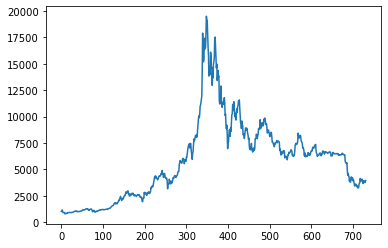

In [3]:
year["Adj Close"].plot()

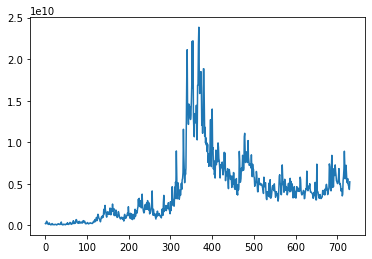

In [368]:
year["Volume"].plot()

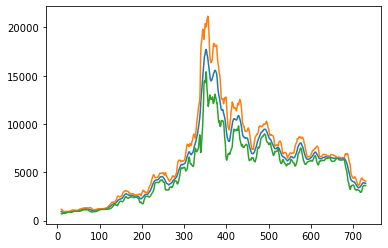

In [6]:
def Bolinger_Bands(stock_price, window_size, num_of_std):

    rolling_mean = stock_price.rolling(window=window_size).mean()
    rolling_std  = stock_price.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)

    return rolling_mean, upper_band, lower_band


mean, upper, lower = Bolinger_Bands(year["Close"], 10, 2)

mean.plot()
upper.plot()
lower.plot()


# Feature Engineering

In [7]:
def get_mov_avg_std(df, col, N = 3):
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out
    

In [8]:
df = year.copy()
df.reset_index(drop = True, inplace = True)

# Get difference between high and low of each day
df['range_hl'] = df['High'] - df['Low']
df.drop(['High', 'Low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['Open'] - df['Close']
df.drop(['Open', 'Close'], axis=1, inplace=True)

# Creating lagging features
lag_nums = [1,2,3]
col = ["Adj Close", "range_hl", "range_oc"]

for num in lag_nums:
    for column in col:
        df["{}_{}".format(column, num)] = [0]*int(num) + list(df["{}".format(column)])[:-num]
        
df = df.iloc[3:]
df.reset_index(inplace = True, drop = True)

# Creating moving averages and standard deviations
cols_list = ["Adj Close", "range_hl", "range_oc", "Volume"]

for col in cols_list:
    df = get_mov_avg_std(df, col)
    
df["Date"] = year["Date"]
    
df.head()

,Date,Adj Close,Volume,range_hl,range_oc,Adj Close_1,range_hl_1,range_oc_1,Adj Close_2,range_hl_2,...,range_hl_3,range_oc_3,Adj Close_mean,Adj Close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,Volume_mean,Volume_std
0,2017-01-02,1013.380005,510199008,280.682984,143.349975,1154.729980,115.020020,-110.329956,1043.839966,22.479980,...,34.687989,-23.132996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-03,902.200989,351876000,162.866089,112.039001,1013.380005,280.682984,143.349975,1154.729980,115.020020,...,22.479980,-22.239990,1013.380005,NaN,280.682984,NaN,143.349975,NaN,5.101990e+08,NaN
2,2017-01-04,908.585022,279550016,85.028992,-5.098022,902.200989,162.866089,112.039001,1013.380005,280.682984,...,115.020020,-110.329956,957.790497,78.615436,221.774537,83.309125,127.694488,22.140202,4.310375e+08,1.119513e+08
3,2017-01-05,911.198975,158715008,55.474976,-3.023987,908.585022,85.028992,-5.098022,902.200989,162.866089,...,280.682984,143.349975,941.388672,62.427982,176.192688,98.505430,83.430318,78.249885,3.805417e+08,1.179662e+08
4,2017-01-06,902.828003,141876992,33.878967,10.416016,911.198975,55.474976,-3.023987,908.585022,85.028992,...,162.866089,112.039001,907.328329,4.628758,101.123352,55.475077,34.638997,67.038391,2.633803e+08,9.759040e+07


In [9]:
df.columns

Index(['Date', 'Adj Close', 'Volume', 'range_hl', 'range_oc', 'Adj Close_1',
       'range_hl_1', 'range_oc_1', 'Adj Close_2', 'range_hl_2', 'range_oc_2',
       'Adj Close_3', 'range_hl_3', 'range_oc_3', 'Adj Close_mean',
       'Adj Close_std', 'range_hl_mean', 'range_hl_std', 'range_oc_mean',
       'range_oc_std', 'Volume_mean', 'Volume_std'],
      dtype='object')

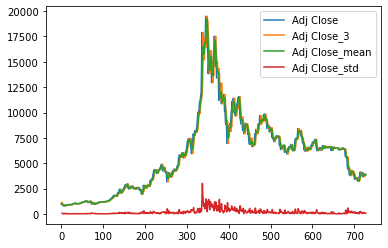

In [10]:
df["Adj Close"].plot(legend = "Adjusted Close")
df["Adj Close_3"].plot(legend = "3 Day lag")
df["Adj Close_mean"].plot(legend = "Average")
df["Adj Close_std"].plot(legend = "Standard Deviation")


In [11]:
import collections
close = df["Adj Close"]
peak = []


for x in range(len(close)-1):
    if close[x+1] > upper[x]:
        peak.append(1)
    else:
        peak.append(0)   
        
peak.append(0)
df["peak"] = peak
df["peak"] = df["peak"].astype("category")
df.drop([0,1,2], inplace = True)
        
counts = collections.Counter(peak)
counts

Counter({0: 547, 1: 181})

Text(0, 0.5, 'Close Value')

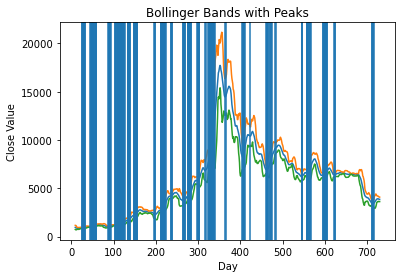

In [12]:
mean.plot()
upper.plot()
lower.plot()

for n in range(len(peak)):
    if peak[n] == 1:
        plt.axvline(x = n)

plt.title("Bollinger Bands with Peaks")
plt.xlabel("Day")
plt.ylabel("Close Value")

In [68]:
df.to_csv("Bitcoin.csv", index = False)

# Splitting Data

In [3]:
df = pd.read_csv("Bitcoin.csv")
df.head()

,Date,Adj Close,Volume,range_hl,range_oc,Adj Close_1,range_hl_1,range_oc_1,Adj Close_2,range_hl_2,...,range_oc_3,Adj Close_mean,Adj Close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,Volume_mean,Volume_std,peak
0,2017-01-05,911.198975,158715008,55.474976,-3.023987,908.585022,85.028992,-5.098022,902.200989,162.866089,...,143.349975,941.388672,62.427982,176.192688,98.505430,83.430318,78.249885,3.805417e+08,1.179662e+08,0
1,2017-01-06,902.828003,141876992,33.878967,10.416016,911.198975,55.474976,-3.023987,908.585022,85.028992,...,112.039001,907.328329,4.628758,101.123352,55.475077,34.638997,67.038391,2.633803e+08,9.759040e+07,0
2,2017-01-07,907.679016,115808000,13.812988,-5.239014,902.828003,33.878967,10.416016,911.198975,55.474976,...,-5.098022,907.537333,4.282701,58.127645,25.677982,0.764669,8.422397,1.933807e+08,7.509825e+07,0
3,2017-01-08,777.757019,310928992,156.682983,130.357971,907.679016,13.812988,-5.239014,902.828003,33.878967,...,-3.023987,907.235331,4.203086,34.388977,20.835676,0.717672,8.471718,1.388000e+08,2.161837e+07,0
4,2017-01-09,804.833984,222326000,70.489991,-29.656005,777.757019,156.682983,130.357971,907.679016,13.812988,...,10.416016,862.754679,73.650083,68.124979,77.346951,45.178324,74.181865,1.895380e+08,1.059327e+08,0


In [4]:
X = df.drop(["Date", "peak"], axis = 1)
y = df["peak"]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Baseline Models

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

In [22]:
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, f1_score

roc_value = roc_auc_score(y_test, rf_predictions)
precision = average_precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
f1 = f1_score(y_test, rf_predictions)

print(" AUC: ", roc_value, "\n", 
      "Precision: ", precision, "\n",
     "Recall: ", recall, "\n",
     "F1: ", f1)

 AUC:  0.7288721953148166 
 Precision:  0.5972242327028031 
 Recall:  0.47761194029850745 
 F1:  0.6274509803921569


### Hyperparameter Tuning (RandomSearch)


In [26]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [27]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.3min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [28]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [29]:
rf_predictions = rf_random.predict(X_test)

roc_value = roc_auc_score(y_test, rf_predictions)
precision = average_precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
f1 = f1_score(y_test, rf_predictions)

print(" AUC: ", roc_value, "\n", 
      "Precision: ", precision, "\n",
     "Recall: ", recall, "\n",
     "F1: ", f1)

 AUC:  0.7114757339132154 
 Precision:  0.5527939277083465 
 Recall:  0.4626865671641791 
 F1:  0.5961538461538461


### Hyperparameter Tuning (GridSearch)


In [30]:
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]

# Maximum number of levels in tree
max_depth = list(range(70, 130, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [1, 2, 3, 4]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]

final_grid = {'n_estimators': n_estimators,
               'max_features': ["auto"],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(final_grid)

{'bootstrap': [True, False],
 'max_depth': [70, 80, 90, 100, 110, 120, None],
 'max_features': ['auto'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [1, 2, 3, 4],
 'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300]}


In [31]:
rf = RandomForestClassifier()

rf_grid = GridSearchCV(estimator = rf, param_grid = final_grid, verbose=2, n_jobs = -1)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 2240 candidates, totalling 11200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 601 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 900 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2360 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3414 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4628 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 6006 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 7544 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 9246 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 11108 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 11200 out of 11200 | elapsed: 13.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=No...
                                              random_state=None, verbose=0,
                                   

In [32]:
rf_predictions = rf_grid.predict(X_test)

roc_value = roc_auc_score(y_test, rf_predictions)
precision = average_precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
f1 = f1_score(y_test, rf_predictions)

print(" AUC: ", roc_value, "\n", 
      "Precision: ", precision, "\n",
     "Recall: ", recall, "\n",
     "F1: ", f1)

 AUC:  0.6550854996540476 
 Precision:  0.48381780481602465 
 Recall:  0.34328358208955223 
 F1:  0.4842105263157894


In [33]:
import pickle as pkl
# save the classifier
with open('random_forest.pkl', 'wb') as fid:
    pkl.dump(rf_grid, fid)    

### XGBoost

In [6]:
import xgboost as xgb

In [7]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [8]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined

In [75]:
predictions = grid.predict(X_test)

roc_value = roc_auc_score(y_test, predictions)
precision = average_precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(" AUC: ", roc_value, "\n", 
      "Precision: ", precision, "\n",
     "Recall: ", recall, "\n",
     "F1: ", f1)

 AUC:  0.7645547098942375 
 Precision:  0.6114508464897841 
 Recall:  0.582089552238806 
 F1:  0.6842105263157895


In [76]:
import pickle as pkl
# save the classifier
with open('xgboost.pkl', 'wb') as fid:
    pkl.dump(grid, fid)    

### LSTM

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
df_dateless = df.drop("Date", axis = 1)

In [11]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(df_dateless)

In [12]:
X_train = []
y_train = []

for i in range(60, len(training_set_scaled)-50):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

Using TensorFlow backend.
C:\Users\Delbert\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Delbert\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Delbert\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Delbert\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [19]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics = ["mape"])
history = model.fit(X_train,y_train,epochs=100,batch_size=32, verbose = 0)

In [20]:
X_test = []
real_stock_price = []
for i in range(len(training_set_scaled)-50, len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, 0])
    real_stock_price.append(training_set_scaled[i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
score = model.evaluate(X_test, real_stock_price)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

50/50 [==============================] - 0s 10ms/step


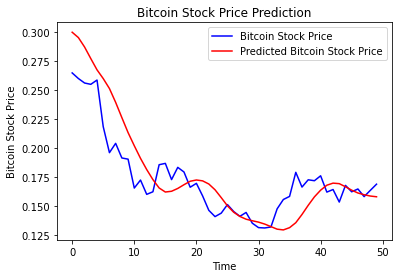

In [230]:
plt.plot(real_stock_price, color = 'blue', label = 'Bitcoin Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Bitcoin Stock Price')
plt.title('Bitcoin Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Stock Price')
plt.legend()
plt.show()

In [22]:
score

[0.00045910874498076735, 9.530631065368652]

# With Sentiments

In [3]:
import pickle
bitcoin = pd.read_csv("bitcoin.csv")
df = pd.read_csv("vader.csv")
manual = pickle.load(open("manually_curated_sentiments_large.pkl", "rb"))
sentiment140 = input_ids = pickle.load(open("sentiment140_sentiments_large.pkl", "rb"))
df["manual"] = manual
df["sentiment140"] = sentiment140
df.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text,vader,manual,sentiment140
0,1.078873e+18,TheBitfi,Bitfi - open source: bitfi.dev,NaN,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in amp no...,0.7678,1,1
1,9.862542e+17,keno_sanders,Keno Sanders,NaN,2018-04-17,1.0,7.0,1.0,Great talk and discussions about Bitcoin vs Eu...,0.7650,2,1
2,9.616666e+17,CryptoGamer_,CryptoGamer,NaN,2018-02-08,23.0,135.0,51.0,When things are down remember its never as bad...,0.0387,2,1
3,9.354113e+17,real_vijay,Vijay Boyapati,NaN,2017-11-28,12.0,509.0,238.0,While there are no a priori rules about the p...,0.4588,2,1
4,1.005368e+18,Ok_coinexchange,OK.NET,NaN,2018-06-09,39.0,324.0,160.0,Wow We reached K followers just within weeks ...,0.9217,1,1


In [4]:
change_dict = {0:"irrelevant", 1:"positive", 2:"neutral", 3:"negative"}
converted_manual = manual.copy()
converted_manual = [change_dict[x] for x in converted_manual]

No handles with labels found to put in legend.


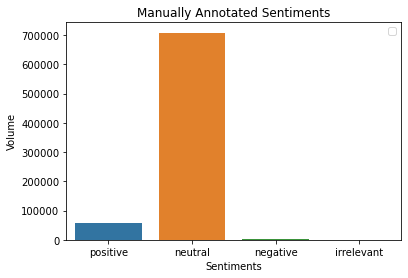

In [341]:
sns.countplot(converted_manual)
plt.title('Manually Annotated Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Volume')
plt.legend()
plt.show()

No handles with labels found to put in legend.


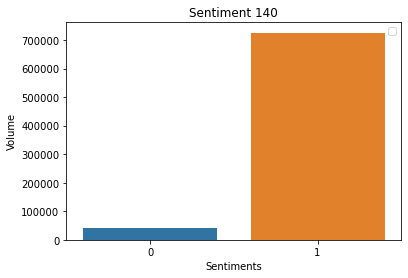

In [252]:
change_dict = {0: "negative", 1: "positive"}
converted_sentiment140 = sentiment140.copy()
sns.countplot(converted_sentiment140)
plt.title('Sentiment 140')
plt.xlabel('Sentiments')
plt.ylabel('Volume')
plt.legend()
plt.show()

No handles with labels found to put in legend.


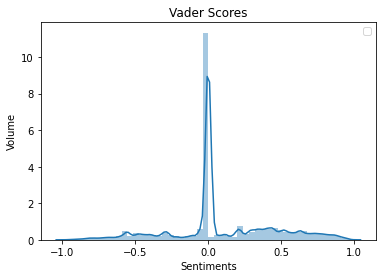

In [253]:
sns.distplot(df["vader"])
plt.title('Vader Scores')
plt.xlabel('Sentiments')
plt.ylabel('Volume')
plt.legend()
plt.show()

### Scaling and Aggregating Sentiments

In [5]:
#Converting to scalable numbers
def convert_manual(x):
    if x == 1:
        return 1
    elif x == 3:
        return -1
    else:
        return 0
    
df["manual"] = df["manual"].apply(convert_manual)

df["sentiment140"] = df["sentiment140"].apply(lambda x: -1 if x == 0 else 1)

#Scaling for likes
df["manual"] = df["manual"].astype(float) * df["likes"].astype(float)

df["sentiment140"] = df["sentiment140"].astype(float) * df["likes"].astype(float)

df["vader"] = df["vader"].astype(float) * df["likes"].astype(float)

#Aggregating
df = df[["timestamp", "vader", "manual", "sentiment140"]]

df = df.groupby("timestamp").sum()
df.reset_index(inplace = True, drop = False)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.head()

,timestamp,vader,manual,sentiment140
0,2017-01-01,3.2784,0.0,21.0
1,2017-01-02,1.4032,0.0,14.0
2,2017-01-03,398.2157,0.0,683.0
3,2017-01-04,0.8354,0.0,29.0
4,2017-01-05,1.7036,0.0,50.0


### Creating Final Table

In [6]:
stocks = pd.read_csv("bitcoin.csv")
stocks["Date"] = pd.to_datetime(stocks["Date"])
df = stocks.merge(df, left_on='Date', right_on='timestamp')
df.head()

,Date,Adj Close,Volume,range_hl,range_oc,Adj Close_1,range_hl_1,range_oc_1,Adj Close_2,range_hl_2,...,range_hl_std,range_oc_mean,range_oc_std,Volume_mean,Volume_std,peak,timestamp,vader,manual,sentiment140
0,2017-01-05,911.198975,158715008,55.474976,-3.023987,908.585022,85.028992,-5.098022,902.200989,162.866089,...,98.505430,83.430318,78.249885,3.805417e+08,1.179662e+08,0,2017-01-05,1.7036,0.0,50.0
1,2017-01-06,902.828003,141876992,33.878967,10.416016,911.198975,55.474976,-3.023987,908.585022,85.028992,...,55.475077,34.638997,67.038391,2.633803e+08,9.759040e+07,0,2017-01-06,0.8458,0.0,17.0
2,2017-01-07,907.679016,115808000,13.812988,-5.239014,902.828003,33.878967,10.416016,911.198975,55.474976,...,25.677982,0.764669,8.422397,1.933807e+08,7.509825e+07,0,2017-01-07,11.9718,0.0,49.0
3,2017-01-08,777.757019,310928992,156.682983,130.357971,907.679016,13.812988,-5.239014,902.828003,33.878967,...,20.835676,0.717672,8.471718,1.388000e+08,2.161837e+07,0,2017-01-08,1.4760,0.0,5.0
4,2017-01-09,804.833984,222326000,70.489991,-29.656005,777.757019,156.682983,130.357971,907.679016,13.812988,...,77.346951,45.178324,74.181865,1.895380e+08,1.059327e+08,0,2017-01-09,0.7877,0.0,16.0


In [7]:
def get_mov_sentiments(df, col, N = 3):
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean' + str(N)] = mean_list
    
    return df_out

cols_list = ["vader", "manual", "sentiment140"]

for col in cols_list:
    df = get_mov_sentiments(df, col)
    df = get_mov_sentiments(df, col, 5)
    df = get_mov_sentiments(df, col, 10)

In [8]:
df = df[df["vader_mean3"].notnull()]
X = df.drop(["Date", "peak", "timestamp"], axis = 1)
y = df["peak"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Random Forest

In [387]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [388]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [389]:
rf_predictions = rf_random.predict(X_test)

roc_value = roc_auc_score(y_test, rf_predictions)
precision = average_precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
f1 = f1_score(y_test, rf_predictions)

print(" AUC: ", roc_value, "\n", 
      "Precision: ", precision, "\n",
     "Recall: ", recall, "\n",
     "F1: ", f1)

 AUC:  0.7441104359876346 
 Precision:  0.5228709894780491 
 Recall:  0.576271186440678 
 F1:  0.6355140186915889


In [391]:
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [392]:
model.feature_importances_

array([0.0240007 , 0.01755196, 0.0229281 , 0.0699661 , 0.0220367 ,
       0.02108938, 0.05463129, 0.0287284 , 0.02016008, 0.06233619,
       0.02628664, 0.03083108, 0.03763704, 0.02543352, 0.01948515,
       0.02607047, 0.02848417, 0.13095587, 0.02316959, 0.02751748,
       0.01873792, 0.02619254, 0.01108943, 0.02215852, 0.0265612 ,
       0.02206864, 0.02231962, 0.01183405, 0.01454113, 0.02597679,
       0.02611279, 0.01812521, 0.03498227])

In [398]:
importance = pd.DataFrame(X_train.columns, model.feature_importances_)
importance.reset_index(inplace = True)
importance.sort_values(by=['index'], ascending = False

,index,0
17,0.130956,range_oc_mean
3,0.069966,range_oc
9,0.062336,range_oc_2
6,0.054631,range_oc_1
12,0.037637,range_oc_3
32,0.034982,sentiment140_mean10
11,0.030831,range_hl_3
7,0.028728,Adj Close_2
16,0.028484,range_hl_std
19,0.027517,Volume_mean


### XG Boost

In [327]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                        

In [328]:
predictions = grid.predict(X_test)

roc_value = roc_auc_score(y_test, predictions)
precision = average_precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(" AUC: ", roc_value, "\n", 
      "Precision: ", precision, "\n",
     "Recall: ", recall, "\n",
     "F1: ", f1)

 AUC:  0.7726788188892443 
 Precision:  0.56498522780283 
 Recall:  0.6271186440677966 
 F1:  0.6788990825688074


### LSTM

In [29]:
df_dateless = df.drop(["Date", "peak", "timestamp"], axis = 1)

sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(df_dateless)

X_train = []
y_train = []

for i in range(60, len(training_set_scaled)-50):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics = ["mape"])
history = model.fit(X_train,y_train,epochs=100,batch_size=32, verbose = 0)



In [30]:
X_test = []
real_stock_price = []
for i in range(len(training_set_scaled)-50, len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, 0])
    real_stock_price.append(training_set_scaled[i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
score = model.evaluate(X_test, real_stock_price)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

50/50 [==============================] - 1s 12ms/step


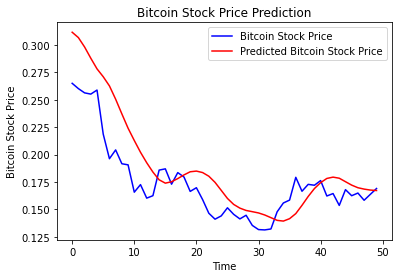

In [331]:
plt.plot(real_stock_price, color = 'blue', label = 'Bitcoin Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Bitcoin Stock Price')
plt.title('Bitcoin Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Stock Price')
plt.legend()
plt.show()

In [31]:
score

[0.0006491801590891555, 11.739989280700684]

# Only Sentiments

In [9]:
sentiments = df[["Adj Close", "vader", "manual", "sentiment140", "peak"]]

for col in cols_list:
    sentiments = get_mov_sentiments(sentiments, col)
    sentiments = get_mov_sentiments(sentiments, col, 5)
    sentiments = get_mov_sentiments(sentiments, col, 10)
    
df = sentiments.copy()
df = df[df["vader_mean3"].notnull()]

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(["peak"], axis = 1)
y = df["peak"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Random Forest

In [353]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.3min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [354]:
rf_predictions = rf_random.predict(X_test)

roc_value = roc_auc_score(y_test, rf_predictions)
precision = average_precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
f1 = f1_score(y_test, rf_predictions)

print(" AUC: ", roc_value, "\n", 
      "Precision: ", precision, "\n",
     "Recall: ", recall, "\n",
     "F1: ", f1)

 AUC:  0.7369517543859648 
 Precision:  0.5057489445914927 
 Recall:  0.5614035087719298 
 F1:  0.6213592233009708


### XGBoost

In [355]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                        

In [356]:
predictions = grid.predict(X_test)

roc_value = roc_auc_score(y_test, predictions)
precision = average_precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(" AUC: ", roc_value, "\n", 
      "Precision: ", precision, "\n",
     "Recall: ", recall, "\n",
     "F1: ", f1)

 AUC:  0.6742324561403509 
 Precision:  0.4645484679440537 
 Recall:  0.38596491228070173 
 F1:  0.5176470588235293


### LSTM

In [15]:
df_dateless = df.drop(["peak"], axis = 1)

sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(df_dateless)

X_train = []
y_train = []

for i in range(60, len(training_set_scaled)-50):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics = ["mape"])
history = model.fit(X_train,y_train,epochs=100,batch_size=32, verbose = 0)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [16]:
X_test = []
real_stock_price = []
for i in range(len(training_set_scaled)-50, len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, 0])
    real_stock_price.append(training_set_scaled[i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
score = model.evaluate(X_test, real_stock_price)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

50/50 [==============================] - 0s 8ms/step


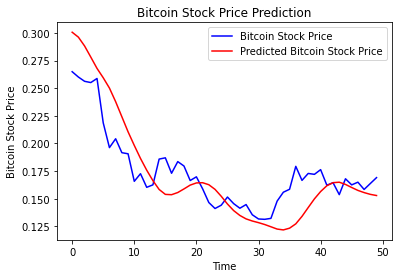

In [360]:
plt.plot(real_stock_price, color = 'blue', label = 'Bitcoin Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Bitcoin Stock Price')
plt.title('Bitcoin Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Stock Price')
plt.legend()
plt.show()

In [17]:
score

[0.0006442087778123095, 12.206494331359863]